In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
/content/drive/My Drive/data


In [ ]:
%cd '/content/drive/My Drive/data'

/content/drive/My Drive/data


In [ ]:
from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob

In [ ]:
path1 = 'chest/Chest_COVID'
path2 = 'chest/Chest_NonCOVID'

In [ ]:
covid_positive = glob(path1 + '/*')
covid_negative = glob(path2 + '/*')

In [ ]:
covid_labels = []
noncovid_labels = []
covid_positive_images=[]
covid_negative_images=[]


In [ ]:
import cv2 
for i in range(len(covid_positive)):
  image = cv2.imread(covid_positive[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  covid_positive_images.append(image)
  covid_labels.append('Chest_COVID')

for i in range(len(covid_negative)):
  image = cv2.imread(covid_negative[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  covid_negative_images.append(image)
  noncovid_labels.append('Chest_NonCOVID')

In [ ]:
#Normalization
covid_positive_images = np.array(covid_positive_images) / 255
covid_negative_images = np.array(covid_negative_images) / 255

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_positive_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    covid_negative_images, noncovid_labels, test_size=0.2)

X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)


In [ ]:
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

In [ ]:
y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

### **Building and Visualizing model**

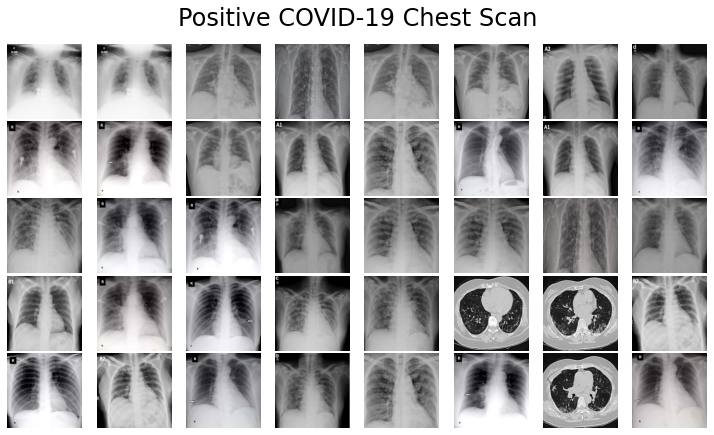

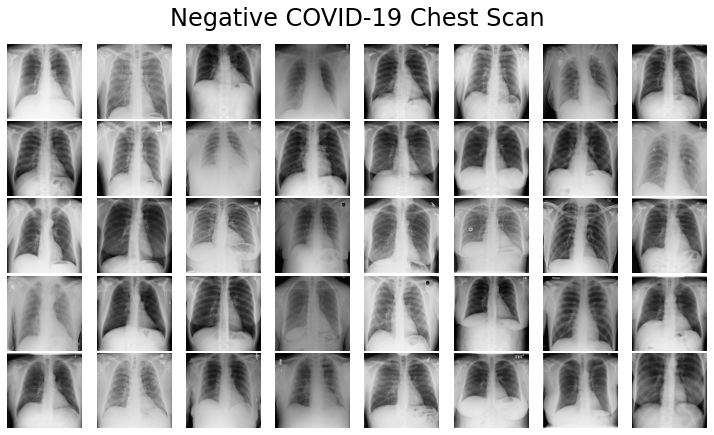

In [ ]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_positive_images, 'Positive COVID-19 Chest Scan')
plot_images(covid_negative_images, 'Negative COVID-19 Chest Scan')

In [ ]:
res = ResNet50(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

last_layer = res.output
# last_layer = Flatten(name="flatten")(last_layer)
last_layer = GlobalAveragePooling2D()(last_layer)
last_layer = Flatten(name="flatten")(last_layer)
last_layer = Dropout(0.5)(last_layer)
# last_layer = Dense(5, activation="relu")(last_layer)
last_layer = Dense(512,activation="relu")(last_layer)
last_layer = Dense(2, activation="softmax")(last_layer)

model = Model(inputs=res.input, outputs=last_layer)

for layer in res.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [ ]:
model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________

### **Training the model**

In [ ]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=10)

Epoch 1/10
24/23 [==============================] - 8s 354ms/step - loss: 3.5603 - accuracy: 0.5013 - val_loss: 3.6368 - val_accuracy: 0.4628
Epoch 2/10
24/23 [==============================] - 8s 321ms/step - loss: 2.1299 - accuracy: 0.4548 - val_loss: 1.1025 - val_accuracy: 0.4628
Epoch 3/10
24/23 [==============================] - 8s 326ms/step - loss: 1.0926 - accuracy: 0.5040 - val_loss: 0.7195 - val_accuracy: 0.5372
Epoch 4/10
24/23 [==============================] - 8s 320ms/step - loss: 1.1192 - accuracy: 0.5013 - val_loss: 0.9143 - val_accuracy: 0.5372
Epoch 5/10
24/23 [==============================] - 8s 315ms/step - loss: 1.0469 - accuracy: 0.4787 - val_loss: 0.7015 - val_accuracy: 0.5372
Epoch 6/10
24/23 [==============================] - 7s 312ms/step - loss: 0.9679 - accuracy: 0.5093 - val_loss: 0.7513 - val_accuracy: 0.4628
Epoch 7/10
24/23 [==============================] - 8s 313ms/step - loss: 1.2061 - accuracy: 0.4694 - val_loss: 1.2919 - val_accuracy: 0.5372
Epoch 

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
%cd '/content/drive/My Drive/model'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/model


In [ ]:
import time as t
timestmp = t.strftime("%d%H%M%S",t.localtime(t.time()))
timestmp
export_path = "Resnet50Chest{}".format(timestmp)
export_path

'Resnet50Chest11071704'

In [ ]:
%cd '/content/drive/My Drive/model'

/content/drive/My Drive/model


In [ ]:
# export_path = "Resnet50Chest{}".format(timestmp)

export_path="Resnet50Chest50EpochTrainable1Dense83"
model.save(export_path)
export_path

INFO:tensorflow:Assets written to: Resnet50Chest50EpochTrainable1Dense83/assets


'Resnet50Chest50EpochTrainable1Dense83'

In [ ]:
from tensorflow.keras.models import load_model
reloaded = load_model("Resnet50Chest11070453")

In [ ]:
reloaded_result_batch = reloaded.predict(X_test, batch_size=batch_size)

In [ ]:
# %cd '/content/drive/My Drive/model'
from tensorflow.keras.models import load_model
model = load_model("Resnet50Chest50EpochTrainable1Dense83")

In [ ]:
y_pred = model.predict(X_test, batch_size=32)

### Visulaizing First 10 predictions

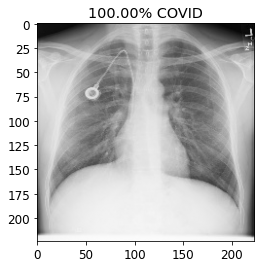

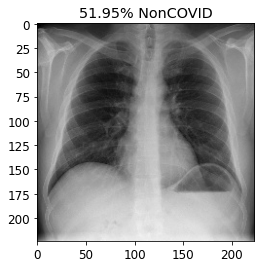

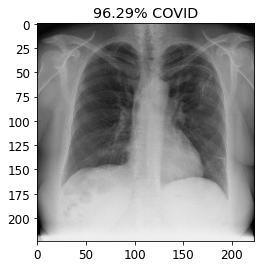

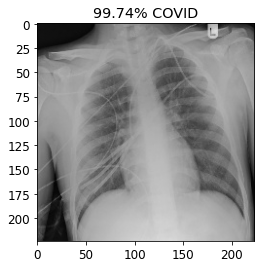

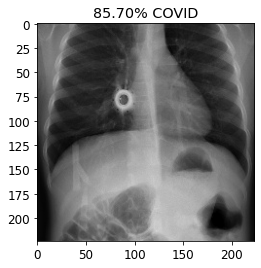

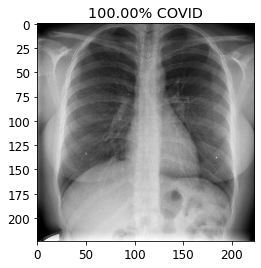

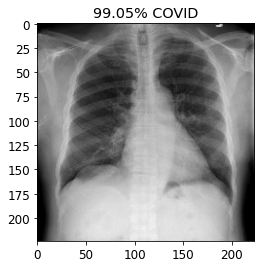

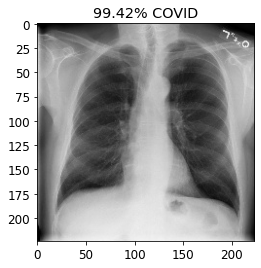

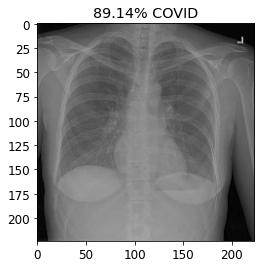

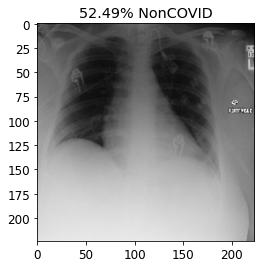

In [ ]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()

In [ ]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

### Plot ROC Curve

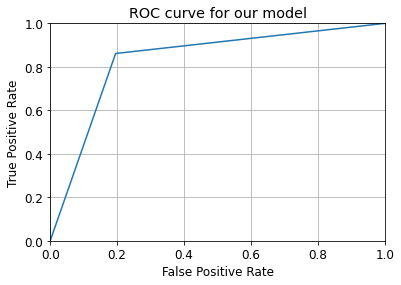

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

### Plot Confusion Matrix

Confusion Matrix without Normalization


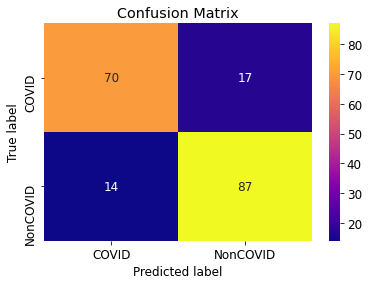

Confusion Matrix with Normalized Values


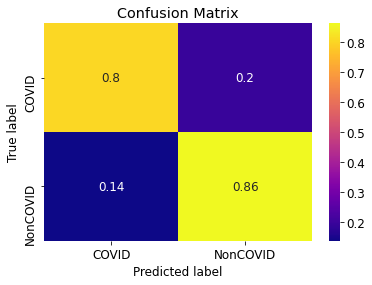

In [ ]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

### **Classification Report**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.83      0.80      0.82        87
           1       0.84      0.86      0.85       101

    accuracy                           0.84       188
   macro avg       0.83      0.83      0.83       188
weighted avg       0.84      0.84      0.83       188



### **Accuracy and Loss Plots**

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('resnet_chest_accuracy.png')
plt.show()


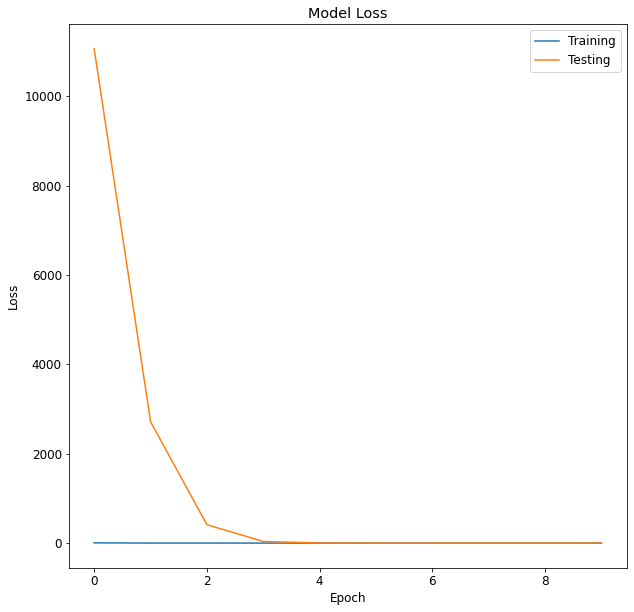

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('resnet_chest_loss.png')
plt.show()

In [ ]:
abs(reloaded_result_batch - y_pred).max()#Zero difference between loaded and saved model

0.0